### Motor Control

Juan Sandubete Lopez
https://github.com/JuanSandu/python_dynamic_sims/blob/master/tutorial_p1/motor_controller.py
https://medium.com/robotics-devs/python-dynamics-simulations-part-1-f89648a35561


Figure 1. Blocks diagram of motor model with controller
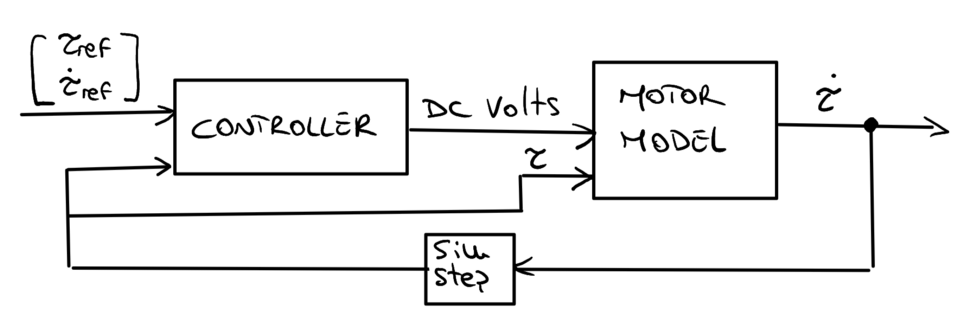

Equation 1. Motor model
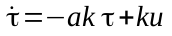

Equation 2. Control law
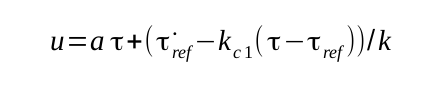

Equation 3. Error dynamics
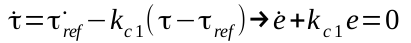

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd

In [22]:
# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "Motor_control_Simulation"

print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3

# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

Starting motor simulation.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller: kc1 = 1


In [23]:
# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

In [24]:
def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)

In [37]:
# The following function puts all equations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    
    return out_states

### Code below is an alternate version - in an attempt to fix for NEW ODE integration function

In [45]:
# The following function puts all equations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    # ...
    if states.isnull().all():
        x1_m = None
    else:
        x1_m, _ = states
    
    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    
    return out_states

In [35]:
# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations
torque_ref = np.sin(time_vector)
print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
torquep_ref = np.cos(time_vector)
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))

# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

Max ref: 0.9999999999931224
Min ref: -0.9999999999993656
Max ref: 1.0
Min ref: -0.9999999999966656


### Simulation

#### ODE integration
- Integrate a system of ordinary differential equations (ODE)
- Solves the initial value problem (IVP) for stiff or non-stiff systems of first order ODEs: dy/dt = func(y, t, ...)

``` scipy.integrate.odeint(connected_systems_model...)```

In [27]:
print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()

# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")


--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 26.48480987548828 sec.

--- SIMULATION Finished. ---



In [30]:
if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

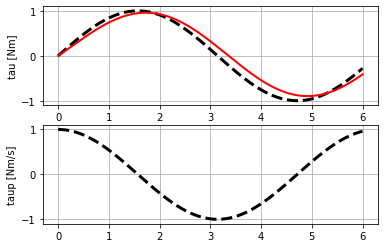

In [31]:
# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

### Simulation

#### ODE integration

``` scipy.integrate.solve_ivp(connected_systems_model...)```

- Solve an initial value problem (IVP) for a system of ODEs.
- This function numerically integrates a system of ordinary differential equations given an initial value:
```
   dy / dt = f(t, y)
   y(t0) = y0 
```

In [46]:
from scipy.integrate import solve_ivp

print("\n-----------------------------------")
print("\n--- Using  scipy.integrate.solve_ivp")
print("\n-----------------------------------")

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
states0 = np.zeros(2)

# Simulate with solve_ivp
t_counter = 0
for i in range(n-1):
    out_states = solve_ivp(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')


-----------------------------------

--- Using  scipy.integrate.solve_ivp

-----------------------------------

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0. 0.]

--- SIMULATION Begins ---



AttributeError: 'float' object has no attribute 'isnull'